In [19]:
import sys
import itertools
from math import sqrt
from operator import add
from os.path import join, isfile, dirname
import math
from pyspark import SparkConf, SparkContext
from pyspark.mllib.recommendation import ALS
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg import SparseVector
from pyspark.mllib.clustering import LDA, LDAModel
from sklearn.neighbors import NearestNeighbors
from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.mllib.util import MLUtils
from pyspark.mllib.regression import LabeledPoint
import textwrap
from datetime import date, datetime
import pyproj
from math import cos, sin
import matplotlib.pyplot as plt

/opt/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [292]:
f = sc.textFile("file:///bgdt/yellow.200000.csv") # file:// for local files (default hdfs)
#f = sc.textFile("file:///bgdt/yellow.50000.csv")
#f = sc.textFile("file:///bgdt/yellow.csv")
header = f.first()
[ str(i) + ' ' + x for i, x in enumerate(header.split(",")) ]

[u'0 VendorID',
 u'1 tpep_pickup_datetime',
 u'2 tpep_dropoff_datetime',
 u'3 passenger_count',
 u'4 trip_distance',
 u'5 pickup_longitude',
 u'6 pickup_latitude',
 u'7 RatecodeID',
 u'8 store_and_fwd_flag',
 u'9 dropoff_longitude',
 u'10 dropoff_latitude',
 u'11 payment_type',
 u'12 fare_amount',
 u'13 extra',
 u'14 mta_tax',
 u'15 tip_amount',
 u'16 tolls_amount',
 u'17 improvement_surcharge',
 u'18 total_amount']

In [303]:
# def hour2ts(h):
#     if h in {}:
        
#     elif

dtf = "%Y-%m-%d %H:%M:%S"  # date format

def defineProj():
    return( pyproj.Proj("+init=epsg:2908 +ellps=WGS84 +datum=WGS84 +proj=utm") )

# theta, xoffset, yoffset are decided by seeing figures
def rotateManhattanY(latm, lonm, theta=-0.496, yoffset=4239000):
    lonm, latm = defineProj()(lonm, latm)
    return( cos(theta)*latm - sin(theta)*lonm - yoffset )

def rotateManhattanX(latm, lonm, theta=-0.496, xoffset=-1635000):
    lonm, latm = defineProj()(lonm, latm)
    return( sin(theta)*latm + cos(theta)*lonm - xoffset )

def inUWS(x, y):
    return(  955 < x and x < 2283 and
            9443 < y and y < 15003 )

def inUpperTimesSquare(x, y):
    return( 1500 < x and x < 4350 and
            8000 < y and y < 9500 )

# translation bounds From: http://www.spatialreference.org/ref/epsg/2908/

univ = f.filter(lambda x: x != header)\
.map(lambda l: l.split(","))\
.map(lambda c:
     {        'pt': c[ 1],
       'isWeekend': int(datetime.strptime(c[1],dtf).isoweekday()>5),
                    # isoweekday() returns Monday as 1, Sundey as 7
              'ph': datetime.strptime(c[1],dtf).hour//2,
              'dt': c[ 2],
             'len': (datetime.strptime(c[2],dtf) -
                     datetime.strptime(c[1],dtf)).seconds // 60,
                    # actual trip duration in minutes
             'dst': float(c[ 4]),
              'po': float(c[ 5]),
              'pa': float(c[ 6]),
              'do': float(c[ 9]),
              'da': float(c[10]),
               '$': c[11], # payment type: 1 is credit card (tip recorded)
            'fare': float(c[12]),
              'ex': float(c[13]),
             'tip': float(c[15]),
            'toll': float(c[16]),
      })\
.filter(lambda x: x['$'] == '1' )\
.filter(lambda x: x['len'] >= 2 )\
.filter(lambda x:  40.4700 < x['pa'] and x['pa'] <  41.3100 and
                  -74.2700 < x['po'] and x['po'] < -71.7500 and
                   x['po'] != 0 and x['pa'] != 0 )\
.map(lambda c:
     { 'isWeekend': c['isWeekend'],
              'ph': c['ph'],
             'len': c['len'],
      'isHighHpay': int((c['tip']*60/c['len'])>=12),
             'dst': c['dst'],
              'po': c['po'],
              'pa': c['pa'],
              'px': rotateManhattanX(c['pa'], c['po']),
              'py': rotateManhattanY(c['pa'], c['po']),
              'do': c['do'],
              'da': c['da'],
            'fare': c['fare'],
              'ex': c['ex'],
            'toll': c['toll']
      })\
.cache()

# can insert before .cache()

# .filter(lambda x: inUWS(x['px'], x['py']) )\
# .filter(lambda x: inUpperTimesSquare(x['px'], x['py']) )\

univ.take(1)

[{'da': 40.74137496948242,
  'do': -73.9216079711914,
  'dst': 3.7,
  'ex': 0.5,
  'fare': 13.0,
  'isHighHpay': 1,
  'isWeekend': 0,
  'len': 10,
  'pa': 40.763179779052734,
  'ph': 0,
  'po': -73.97831726074219,
  'px': 2813.6340825366788,
  'py': 9121.65619494114,
  'toll': 0.0}]

In [294]:
nrCards = univ.count()
print("%d credit card trips" % (nrCards) )

106423 credit card trips


In [295]:
#preped = univ.map(lambda l: (l['dst'], l['tip']) )
moment = 'finished'

if moment == 'before': 
    print("use before")
    preped = univ.map(lambda l:
                      LabeledPoint(l['isHighHpay'],
                                   [l['isWeekend'], l['po'], l['pa'], l['ph'], l['ex']]))
elif moment == 'during':
    print("use during")
    preped = univ.map(lambda l:
                      LabeledPoint(l['isHighHpay'],
                                   [l['isWeekend'], l['po'], l['pa'], l['ph'], l['ex'],
                                    l['dst'], l['toll']
                                   ]))
else:
    print("use finished")
    preped = univ.map(lambda l:
                      LabeledPoint(l['isHighHpay'],
                                   [l['isWeekend'], l['po'], l['pa'], l['ph'], l['ex'],
                                    l['dst'], l['toll'],
                                    l['fare'], l['len'], l['do'], l['da']
                                   ]))

preped.take(1)

use finished


[LabeledPoint(1.0, [0.0,-73.969329834,40.7635383606,0.0,0.5,2.43,0.0,12.0,15.0,-73.9956893921,40.7442512512])]

In [241]:
trRDD, vaRDD, teRDD = preped.randomSplit([6,2,2], seed=0L)

print("  training RDD:", trRDD.take(1))
print("validation RDD:", vaRDD.map(lambda x: x.features ).take(1))

('  training RDD:', [LabeledPoint(1.0, [0.0,-74.0043029785,40.7422409058,0.0,0.5,3.7,0.0,14.0,14.0,-74.0073623657,40.7069358826])])
('validation RDD:', [DenseVector([0.0, -73.9821, 40.7747, 0.0, 0.5, 1.7, 0.0, 7.0, 4.0, -73.9709, 40.7967])])


In [123]:
model = RandomForest.trainClassifier(trRDD, numClasses=2,
                                     categoricalFeaturesInfo = {},
                             numTrees=50, featureSubsetStrategy="sqrt",
                            impurity="gini", maxDepth=4, maxBins=32, seed = 1)
# gini is faster

In [124]:
model

TreeEnsembleModel classifier with 50 trees

In [125]:
preds = model.predict(vaRDD.map(lambda x: x.features ))

In [126]:
labelsAndPredictions = vaRDD.map(lambda lp: lp.label).zip(preds)


In [127]:
testErr = labelsAndPredictions.filter(lambda (v, p): v != p).count() / float(vaRDD.count())
print('Test Accuracy = %f percent' % (100-round(testErr,7)*100))
# print('Learned classification forest model:')
# print(model.toDebugString()) # messy

Test Accuracy = 75.432530 percent


In [128]:
nActuNotHigh = labelsAndPredictions.filter(lambda lp: lp[0] == 0 ).count()
nActuHigh    = labelsAndPredictions.filter(lambda lp: lp[0] == 1 ).count()
nPredNotHigh = labelsAndPredictions.filter(lambda lp: lp[1] == 0 ).count()
nPredHigh    = labelsAndPredictions.filter(lambda lp: lp[1] == 1 ).count()

print("Baseline : %f     " % (float(max(nActuNotHigh,nActuHigh)) / float(nActuNotHigh+nActuHigh)))
print("Actual  0: %9d    1: %9d     " % (nActuNotHigh, nActuHigh) )
print("Predict 0: %9d    1: %9d     " % (nPredNotHigh, nPredHigh) )

Baseline : 0.690585     
Actual  0:      1699    1:      3792     
Predict 0:      1000    1:      4491     


In [6]:
model.save(sc, "myRandomForestModel")
# Note: for unfiltered data,
# 69 -before-> 72% -finish-> 75%
#
#

NameError: name 'model' is not defined

In [48]:
#
# terms
#
# SRS/CRS: spatial reference system, coordinate reference system
#   = (datum, coord. system, map projection, ...)
#
# Earth ellipsoid: approximation of the shape of the Earth
#   ex. WGS84 ellipsoid (used in GPS)
#       en.wikipedia.org/wiki/Earth_ellipsoid#Historical_Earth_ellipsoids
#
# Spatial datum (geodetic datum): (a coord. system, reference points) 
#   ex. WGS84 (World Geodetic System 1984), NAD83, ...
#
# Geographic coordinates: (longitude, latitude)
#
# Map projection (to developable surface):
#   (longitude, latitude) --> Cartesian (x, y)
#
#  SRID: Spatial Reference System Identifier by many vendors
#    ex. European Petroleum Survey Group (EPSG) provides EPSG SRID
#    SRID is used to identify what projection is used.
#    GIS uses the local coordinate system
#
# For proj.4 parameters:
# https://github.com/OSGeo/proj.4/wiki/GenParms
#
#
# offset lon: 978000 lat: 190000
# lon lat (-73.94804, 40.78445) -> (1175.099 40681.49)
#
p = pyproj.Proj("+init=epsg:2908 +ellps=WGS84 +datum=WGS84 +proj=longlat +units=m")
pom, pam = p(-73.94804, 40.78445)
print("%f, %f" % (pom, pam) )
theta = -.503
ry = cos(theta) * pam - sin(theta) * pom
rx = sin(theta) * pam + cos(theta) * pom
print("%f, %f" % (rx, ry) )

0.000907, 0.711823
-0.342344, 0.624094


In [304]:
dots = univ.take(200000)

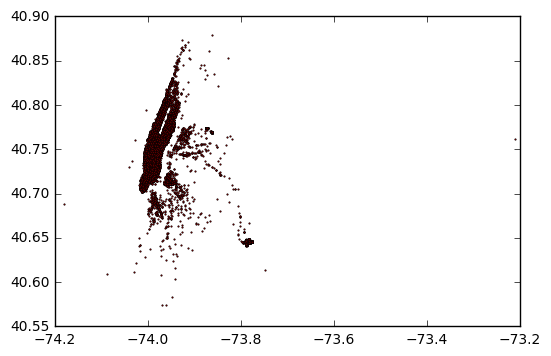

In [247]:
plt.plot([ x['po'] for x in dots[1:50000] ],
         [ x['pa'] for x in dots[1:50000] ], 'ro', markersize=1)
#plt.axis([0, 6, 0, 20])
plt.show()

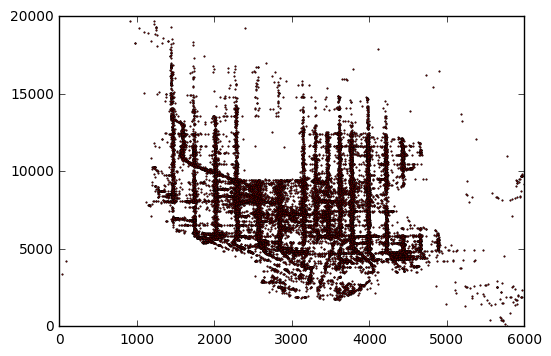

In [249]:
plt.plot([ x['px'] for x in dots[1:50000] ],
         [ x['py'] for x in dots[1:50000] ], 'ro', markersize=1)
plt.xlim(xmin=0, xmax=6000)
plt.ylim(ymin=0, ymax=20000)
plt.show()

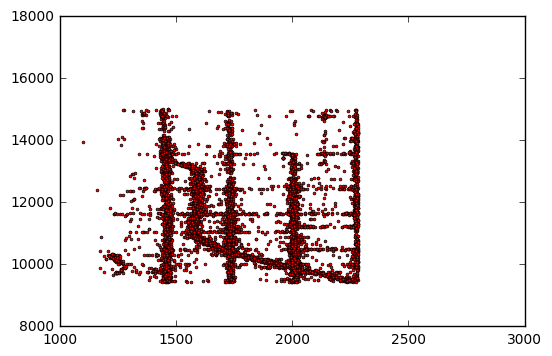

In [283]:
# UWS
plt.plot([ x['px'] for x in dots[1:9000] ],
         [ x['py'] for x in dots[1:9000] ], 'ro', markersize=2)
plt.xlim(xmin=1000, xmax=3000)
plt.ylim(ymin=8000, ymax=18000)
plt.show()

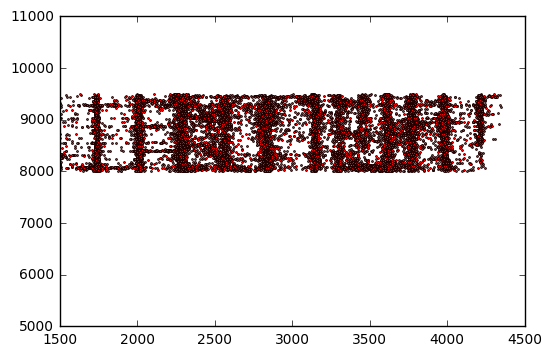

In [305]:
# Upper Times Square
plt.plot([ x['px'] for x in dots[1:100000] ],
         [ x['py'] for x in dots[1:100000] ], 'ro', markersize=1.4)
plt.xlim(xmin=1500, xmax=4500)
plt.ylim(ymin=5000, ymax=11000)
plt.show()

In [256]:

# def rotateManhattanY(latm, lonm, theta=-0.496, yoffset=4239000):
#     # theta, xoffset, yoffset are decided by seeing figures
#     return([(cos(theta)*la - sin(theta)*lo - yoffset) for la,lo in zip(latm, lonm) ])
# def rotateManhattanX(latm, lonm, theta=-0.496, xoffset=-1635000):
#     return([(sin(theta)*la + cos(theta)*lo - xoffset)  for la,lo in zip(latm, lonm) ]) 

# MAYBE-LATER: currently it works but needs more explicit settings.
# 
# p = pyproj.Proj("+init=epsg:2908 +ellps=WGS84 +datum=WGS84 +proj=utm")



# poms, pams = p([ x['po']   for x in dots[1:40000] ],
#                [ x['pa']   for x in dots[1:40000] ])
# print("pom, pam = (%f, %f)" % (poms[0], pams[0]) )

# px = rotateManhattanX(pams, poms, theta)
# py = rotateManhattanY(pams, poms, theta)

# print("px,py = (%f, %f)" % (px[0], py[0]) )

# plt.plot(dots[1:1000]['px'],dots[1:1000]['py'], 'ro', markersize=.5 )
# plt.xlim(xmin=0, xmax=6000)
# plt.ylim(ymin=0, ymax=20000)

# plt.show()

In [269]:
# Upper West Side
print("Teachers College - 121st Y: %5f" % rotateManhattanY(latm= 40.811176, lonm = -73.961526) )
print("The Northern End - 125st Y: %5f" % rotateManhattanY(latm= 40.815378, lonm = -73.958365) )
print("The Southern End - 59st Y: %5f" %  rotateManhattanY(latm= 40.771913, lonm = -73.991137) )
print("The Western End (Bay): %5f" %      rotateManhattanX(latm= 40.772487, lonm = -73.996697) )
print("The Eastern End - Cent. Park %5f"% rotateManhattanX(latm= 40.769585, lonm = -73.980830) )




Teachers College - 121st Y: 14466.660687
The Northern End - 125st Y: 15003.933584
The Southern End - 59st Y: 9443.014457
The Western End (Bay): 955.688724
The Eastern End - Cent. Park 2282.630162


In [302]:
print("Times Square %5f"% rotateManhattanY(latm= 40.758591, lonm = -73.984795) )

Times Square 8410.672915
